<a href="https://colab.research.google.com/github/PapaJacque16/CS-450-Capstone/blob/main/PCR_and_Optimization_of_Sensor_Faults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#Step 1 - Initial Set Up - Import all necessary Libraries and mount to gdrive to import dataset, then perform train test split.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
df = pd.read_csv('/content/gdrive/MyDrive/CS450/Sensor_Time_Series.csv')
df

,Time_Series,Sensor_1_Range,Sensor_2_Range,Temp_High,Temp_Low,Performance
0,3/21/22 0:00,12.162611,13.816756,190.17,139.47,49.045854
1,3/21/22 0:01,12.252904,14.100229,187.41,139.48,46.082675
2,3/21/22 0:02,12.171030,13.981956,190.71,139.66,49.239073
3,3/21/22 0:03,12.121374,13.939545,190.89,139.84,49.231828
4,3/21/22 0:04,12.087014,14.058108,191.02,139.86,49.188905
...,...,...,...,...,...,...
10075,3/27/22 23:55,12.686857,14.204982,191.49,140.67,49.301875
10076,3/27/22 23:56,12.651416,14.201341,191.48,140.78,49.150075
10077,3/27/22 23:57,12.638795,13.897180,191.41,140.80,49.351615
10078,3/27/22 23:58,12.575106,13.997841,191.43,140.74,49.267265


In [ ]:
X =  df[['Sensor_1_Range',	'Sensor_2_Range',	'Temp_Low']]
y = df['Temp_High']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=32)

In [ ]:
#Step 2 - Before we can run Principle Component Regression we have to standardize the features to be the same scale then we can generate the components.
#Run standardization on X variables
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

In [ ]:
#Step 3 - Run baseline regression models - Benchmarks for comparison, using 3 baseline models- Linear Regression, Lasso Regression, and Ridge Regression.
#Define cross validation folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
#Linear Regression
lin_reg = LinearRegression().fit(X_train_scaled, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test_scaled), squared=False)

In [ ]:
#Lasso Regression
lasso_reg = LassoCV().fit(X_train_scaled, y_train)
lasso_score_train = -1 * cross_val_score(lasso_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lasso_score_test = mean_squared_error(y_test, lasso_reg.predict(X_test_scaled), squared=False)

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Fatal error from Anvil server: Incorrect uplink key
Anvil websocket closed (code 1000, reason=b'')


In [ ]:
#Ridge Regression
ridge_reg = RidgeCV().fit(X_train_scaled, y_train)
ridge_score_train = -1 * cross_val_score(ridge_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
ridge_score_test = mean_squared_error(y_test, ridge_reg.predict(X_test_scaled), squared=False)

In [ ]:
#Step 4 - Generate Principle Components- generated from sklearn.decomposition
pca = PCA() # Default n_components = min(n_samples, n_features)
X_train_pc = pca.fit_transform(X_train_scaled)

# View first 5 rows of all principal components
pd.DataFrame(pca.components_.T).loc[:4,:]

,0,1,2
0,0.703490,-0.042489,0.709434
1,0.691833,-0.187566,-0.697270
2,0.162692,0.981333,-0.102555


In [ ]:
# View explained variance ratio for each principle component
pca.explained_variance_ratio_

array([0.37963436, 0.33255794, 0.2878077 ])

From the above, we can see that the first principal component (PC1) captures overall 38% of the variance followed by PC2 with a 3.46% variance.

In [ ]:
#Step 5 - Determine the number of Principle Components
#Initialize linear regression instance
lin_reg = LinearRegression()

In [ ]:
#Create empty list to store RMSE for each iteration
rmse_list = []

In [ ]:
# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)

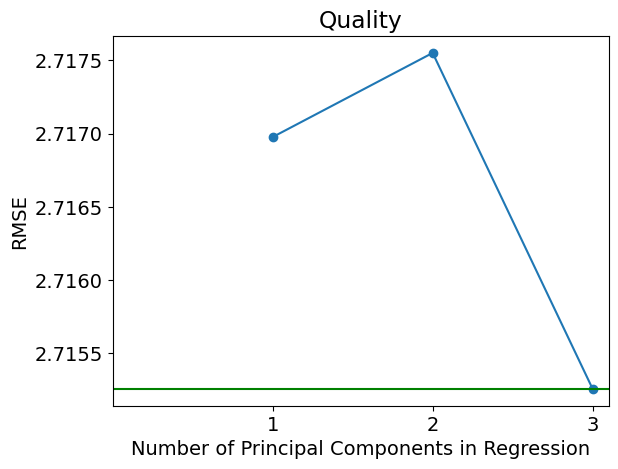

In [ ]:
# Visual analysis - plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of Principal Components in Regression')
plt.ylabel('RMSE')
plt.title('Quality')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

##Results 
The PCR is telling us that based on the quality related process monitoring for the system being used that the smaller number of principal components represents most of the variability in the data and (presumptively) the relationship with the target variable. In this case the quality from PC1 to PC3 varies less than 0.002.

# Fault detection

Now we will consider a problem of identifying faults that have occurred in a system based on sensor measurements of system performance.

# Topic references
- [Samar, Sikandar, Dimitry Gorinevsky, and Stephen Boyd. "Likelihood Bounds for Constrained Estimation with Uncertainty." Decision and Control, 2005 and 2005 European Control Conference. CDC-ECC'05. 44th IEEE Conference on. IEEE, 2005.](http://web.stanford.edu/~boyd/papers/pdf/map_bounds.pdf)

# Problem statement

Each of $n$ possible faults occurs independently with probability $p$.
The vector $x \in \lbrace 0,1 \rbrace^{n}$ encodes the fault occurrences, with $x_i = 1$ indicating that fault $i$ has occurred.
System performance is measured by $m$ sensors.
The sensor output is
\begin{equation}
y = Ax + v = \sum_{i=1}^n a_i x_i + v,
\end{equation}
where $A \in \mathbf{R}^{m \times n}$ is the sensing matrix with column $a_i$ being the **fault signature** of fault $i$,
and $v \in \mathbf{R}^m$ is a noise vector where $v_j$ is Gaussian with mean 0 and variance $\sigma^2$.

The objective is to guess $x$ (which faults have occurred) given $y$ (sensor measurements).

We are interested in the setting where $n > m$, that is, when we have more possible faults than measurements.
In this setting, we can expect a good recovery when the vector $x$ is sparse.
This is the subject of compressed sensing.

# Solution approach
To identify the faults, one reasonable approach is to choose $x \in \lbrace 0,1 \rbrace^{n}$ to minimize the negative log-likelihood function

\begin{equation}
\ell(x) = \frac{1}{2 \sigma^2} \|Ax-y\|_2^2 +  \log(1/p-1)\mathbf{1}^T x + c.
\end{equation}

However, this problem is nonconvex and NP-hard, due to the constraint that $x$ must be Boolean.

To make this problem tractable, we can relax the Boolean constraints and instead constrain $x_i \in [0,1]$.

The optimization problem

\begin{array}{ll}
\mbox{minimize} &  \|Ax-y\|_2^2 + 2 \sigma^2 \log(1/p-1)\mathbf{1}^T x\\
\mbox{subject to} &  0 \leq x_i \leq 1, \quad i=1, \ldots n
\end{array}

is convex.
We'll refer to the solution of the convex problem as the **relaxed ML** estimate.

By taking the relaxed ML estimate of $x$ and rounding the entries to the nearest of 0 or 1, we recover a Boolean estimate of the fault occurrences.

# Example

We'll generate an example with $n = 10080$ possible faults, $m = 1015$ measurements, and fault probability $p = 0.01$.
We'll choose $\sigma^2$ so that the signal-to-noise ratio is 4.
That is,
\begin{equation}
\sqrt{\frac{\mathbf{E}\|Ax \|^2_2}{\mathbf{E} \|v\|_2^2}} = 4.
\end{equation}

In [ ]:
np.random.seed(1)

n = 10080
m = 1015
p = 0.002
snr = 4

sigma = np.sqrt(p*n/(snr**2))
A = np.random.randn(m,n)

x_true = (np.random.rand(n) <= p).astype(int)
v = sigma*np.random.randn(m)

y = A.dot(x_true) + v

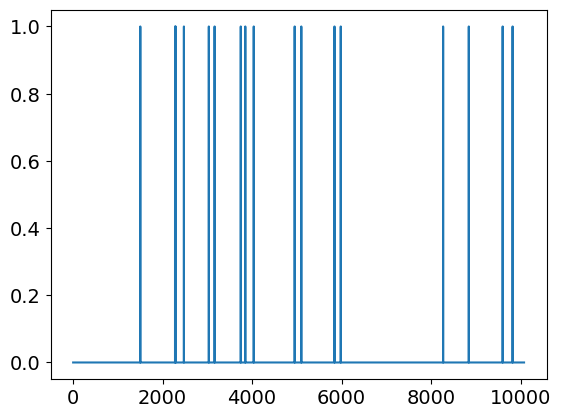

In [ ]:
plt.plot(range(n),x_true);

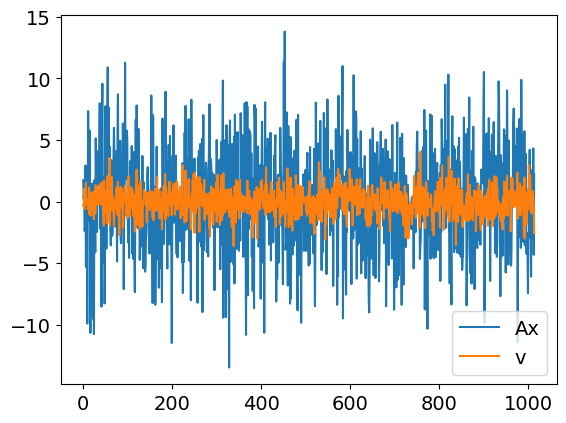

In [ ]:
plt.plot(range(m), A.dot(x_true),range(m),v)
plt.legend(('Ax','v'));

We solve the relaxed maximum likelihood problem with CVXPY and then round the result to get a Boolean solution.

In [ ]:
%%time
import cvxpy as cp
x = cp.Variable(shape=n)
tau = 2*cp.log(1/p - 1)*sigma**2
obj = cp.Minimize(cp.sum_squares(A*x - y) + tau*cp.sum(x))
const = [0 <= x, x <= 1]
cp.Problem(obj,const).solve(verbose=True)
print("final objective value: {}".format(obj.value))

# relaxed ML estimate
x_rml = np.array(x.value).flatten()

# rounded solution
x_rnd = (x_rml >= .5).astype(int)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Apr 03 06:48:48 AM: Your problem has 10080 variables, 2 constraints, and 0 parameters.
(CVXPY) Apr 03 06:48:48 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 03 06:48:48 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 03 06:48:48 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 03 06:48:48 AM: Compiling problem (target solver=OSQP).
(CVXPY) Apr 03 06:48:48 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuff

/usr/local/lib/python3.9/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Fatal error from Anvil server: Incorrect uplink key
Anvil websocket closed (code 1000, reason=b'')
(CVXPY) Apr 03 06:48:57 AM: Applying reduction OSQP
(CVXPY) Apr 03 06:48:58 AM: Finished problem compilation (took 9.754e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Apr 03 06:48:58 AM: Invoking solver OSQP  to obtain a solution.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Fatal error from Anvil server: Incorrect uplink key
Anvil websocket closed (code 1000, reason=b'')
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
  

Evaluation: We define a function for computing the estimation errors, and a function for plotting  𝑥 , the relaxed ML estimate, and the rounded solutions.

In [ ]:
import matplotlib

def errors(x_true, x, threshold=.5):
    '''Return estimation errors.
    
    Return the true number of faults, the number of false positives, and the number of false negatives.
    '''
    n = len(x_true)
    k = sum(x_true)
    false_pos = sum(np.logical_and(x_true < threshold, x >= threshold))
    false_neg = sum(np.logical_and(x_true >= threshold, x < threshold))
    return (k, false_pos, false_neg)

def plotXs(x_true, x_rml, x_rnd, filename=None):
    '''Plot true, relaxed ML, and rounded solutions.'''
    matplotlib.rcParams.update({'font.size': 14})
    xs = [x_true, x_rml, x_rnd]
    titles = ['x_true', 'x_rml', 'x_rnd']

    n = len(x_true)
    k = sum(x_true)

    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 3))

    for i,x in enumerate(xs):
            ax[i].plot(range(n), x)
            ax[i].set_title(titles[i])
            ax[i].set_ylim([0,1])
            
    if filename:
        fig.savefig(filename, bbox_inches='tight')
        
    return errors(x_true, x_rml,.5)

(17, 0, 0)

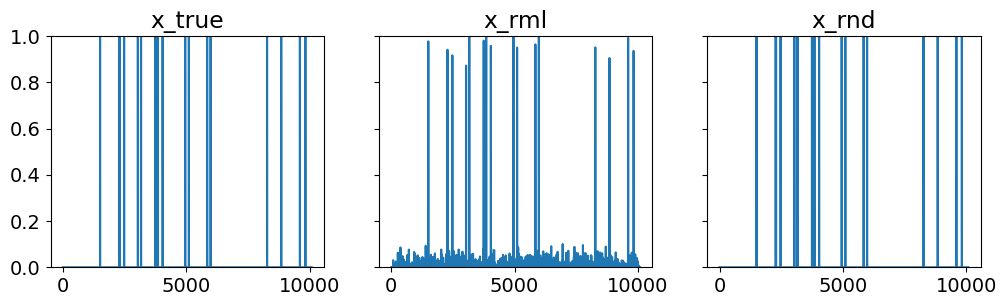

In [ ]:
plotXs(x_true, x_rml, x_rnd, 'fault.pdf')

Out of the evaluation, we found that there was a total of 17 sensor fault issues detected, an the solutions recovery has 0 false negatives and 0 false positives.